This notebook: 
1. loads disp rate maps and residual stds (rmse) for one time period, plots them. 
2. loads avg coh, coh std, amp dispersion, and avg amp files.
3. plot velocity maps masked by threshold values
4. optional: interpolates the masked vel. maps from just "good" or just "bad" data. 
5. calculates and plots skewness and std over a moving window over velocity map.
6. calculates and plots the Guassian-filtered, masked velocity map. 

This notebook was copied and edited on 5-10-23, 6-21-23.

***

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from scipy import signal
%matplotlib  widget 

Use filt? Or unfilt?

In [2]:
# choose 'filt' or 'unfilt'
key1 = 'unfilt'
# choose one: 'avg_val' or 'ref_box' or 'ref_pix'
key2 = 'ref_pix'

Load dates of SLCs/igrams and set directories.

In [3]:
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
dx = 3000
dy = 750

# larger cropped area with western mountains 
dx = 4000
dy = 1100

# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
# set the driver first, only do once.
#driver=gdal.GetDriverByName('ISCE')

Define the intervals.

In [4]:
start_indices = [0,47,108,147,0,0,107]
end_indices = [46,107,146,numIgrams,88,numIgrams,153]
num_intervals = len(end_indices)
# the last one I just added (4-12-23) as a totally dry period

for i in range(num_intervals):
    print('interval '+str(i)+': '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
print(str(num_intervals)+' intervals.')

interval 0: 20170510-20181125
interval 1: 20181207-20200412
interval 2: 20200418-20201208
interval 3: 20201214-20220108
interval 4: 20170510-20191220
interval 5: 20170510-20220108
interval 6: 20200412-20210119
7 intervals.


Choose which interval to plot for all the following plots. 

In [5]:
j = 2; i = j

Read in disp rate maps and residual std maps.

In [6]:
# read in disp rate file + rmse file
fileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'.r4'
errorFileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'_residual_std.r4'

# fileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'_wrap_errs_removed_v2.r4'
# wrapErrFileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'_num_wrap_errs_v2.r4'


saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/12_rate_inversions/disp_rate_maps_with_western_mtns/'
disp_rates = np.ndarray((dy,dx),dtype='float') 
disp_rates_errors = np.ndarray((dy,dx),dtype='float') 
f1 = gdal.Open(saveDir+fileName, gdal.GA_ReadOnly)
disp_rates = f1.ReadAsArray()
f1 = None
f1 = gdal.Open(saveDir+errorFileName, gdal.GA_ReadOnly)
#f1 = gdal.Open(saveDir+wrapErrFileName, gdal.GA_ReadOnly)
disp_rates_errors = f1.ReadAsArray()
f1 = None
#print('interval '+str(j)+' disp rate map + errors loaded.')
print('interval '+str(j)+' disp rate map + wrap error files loaded.')

interval 2 disp rate map + wrap error files loaded.


Plot the disp rate map and the map of errors.

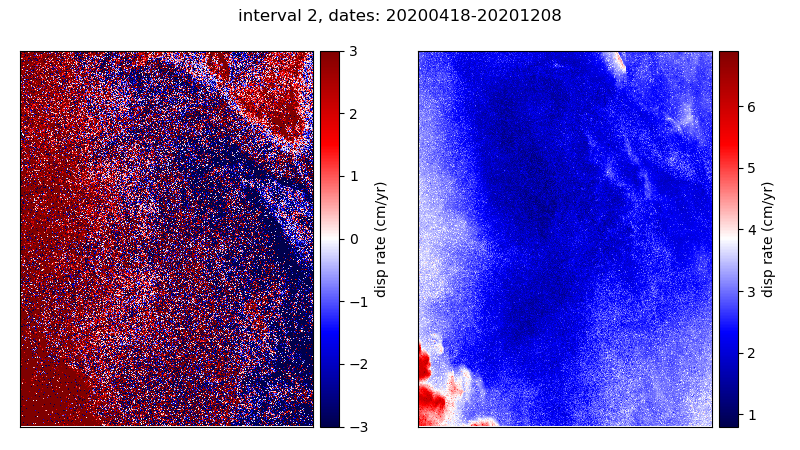

In [7]:
i = j # for 0-3 I used vmin=-5.0,vmax=5.0, but for 4-5 I used vmin=-3.0, vmax=3.0
#print('interval '+str(i)+', dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.figure(figsize=(8,4.5),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(disp_rates, aspect='auto', vmin=-3.0,vmax=3.0,\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(disp_rates_errors, aspect='auto',\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.suptitle('interval '+str(i)+', dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.show()

Now load files:
1. avg coherence
2. std of coherence
3. amp dispersion
4. avg amp
5. unwrap errors

In [8]:
loadDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'

file_name = 'coh_avg.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
coh_avg = f1.ReadAsArray(); f1 = None
print('Avg coh values map loaded.')

file_name = 'coh_std.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
coh_std = f1.ReadAsArray(); f1 = None
print('Std of coh map loaded.')

file_name = 'amp_dispersion.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
amp_dispersion = f1.ReadAsArray(); f1 = None
print('Amplitude dispersion for each pixel loaded.')

file_name = 'avg_amp.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
avg_amp = f1.ReadAsArray(); f1 = None
print('Average amp for each pixel loaded.')

file_name = 'unfilt_unwrapped/wrap_err.i1' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
wrap_err = f1.ReadAsArray(); f1 = None
print('wrap errors for each pixel loaded.')

file_name = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/hpcor.r4' 
f1 = gdal.Open(file_name, gdal.GA_ReadOnly)
hp = f1.ReadAsArray(); f1 = None
# cropped area
x1 = 18000; x2 = 14000
y1 = 2100; y2 = 1000
hp_phs = hp[y2:y1,x2:x1]
print('high pass phase for each pixel loaded.')

Avg coh values map loaded.
Std of coh map loaded.
Amplitude dispersion for each pixel loaded.
Average amp for each pixel loaded.
wrap errors for each pixel loaded.
high pass phase for each pixel loaded.


Make a colormap where Nans are different color: try green.

In [9]:
seismic2 = plt.cm.get_cmap("seismic").copy()
seismic2.set_bad(color='green')
print('colormap made where NANs will be green.')

colormap made where NANs will be green.


Now define a function to do all the steps.

In [ ]:
# convolve a gaussian kernel instead of using gaussian_filter 
def mask_smooth(masked_array,disp_rates,dy,dx):
    #mask_y,mask_x = np.nonzero(masked_array)    # find pix where values haven't been masked
    mask = np.zeros((dy,dx))                    # initialize an array of zeros that's the same size as input for the mask
    mask[np.nonzero(masked_array)] = 1.0                   # put 1's in the spots that had real values 
    #alooks = 4                                  # amount to filter in the azimuth/y direction
    alooks = 8
    #rlooks = 20                                 # amount to filter in the range/x direction
    rlooks = 40 # TRY THIS 
    
    # create Gaussian kernel with proper size
    stdrg = alooks # range, usually rlooks
    stdaz = rlooks # azimuth, usually alooks 
    kernlenrg = 8*stdrg+1 # can try this as 2 
    kernlenaz = 8*stdaz+1
    kernrg = signal.gaussian(kernlenrg, std=stdrg) #.reshape(kernlenrg,1)
    kernaz = signal.gaussian(kernlenaz, std=stdaz) #.reshape(kernlenaz,1)
    wind = np.outer(kernrg,kernaz)
    wind = wind/np.sum(wind)

    print('kernel created.')
    
    mask_filt = signal.convolve2d(mask, wind, mode='same')  # filter the mask to smear it out   
    
    print('kernel convolved with mask.')
    
    # Nans_y,Nans_x = np.where(mask_filt==0)      # find where the filtered mask didn't reach (which pix are still 0)
    vels_masked = np.zeros((dy,dx))             # initialize array of zeros that's the same size as input for the velocities
    vels_masked[np.nonzero(masked_array)] = disp_rates[np.nonzero(masked_array)]      # put in the "good" disp rates into the masked vels array.
    vels_filt = signal.convolve2d(vels_masked, wind, mode='same')  # filter the vels_masked 
    
    print('kernel convolved with masked velocities.')    
    
    # divide the two
    ab_Nans = vels_filt / mask_filt     # start with an array that will have some Nans in it. 
    ab = np.copy(ab_Nans)               # make a copy of it to put zeros back in for the Nans.
    ab[mask_filt==0] = 0.0             # this is where it gave 0/0=Nan, put zeros back in. 
    
    print('convolved velocities divided by convolved mask.')
    
    # calculate the variance of the velocity 
    #residuals_Nans = masked_array-ab                   # removed on avg the mean, this is (value-mean) 
    residuals_Nans = np.zeros((dy,dx))*np.nan           # start with array of Nans
    residuals_Nans[np.nonzero(masked_array)] = disp_rates[np.nonzero(masked_array)]-ab[np.nonzero(masked_array)]     
    # above is residuals of filtered vels for non-masked pixels, minus original vels for non-masked pixels
    residuals2_Nans = np.square(residuals_Nans)                     # (value-mean)^2
    residuals2 = np.zeros((dy,dx))                                  # start with array of zeros
    residuals2[np.nonzero(masked_array)] = residuals2_Nans[np.nonzero(masked_array)]      # picking out values from mask where residuals are meaningful 

    print('residuals and residuals^2 calculated between input vels and smoothed vels.')
    
    var_filt = signal.convolve2d(residuals2, wind, mode='same')    # avg of the (value-mean)^2

    print('residuals convolved with window to get smoothed variances.')

    var_multiplier = signal.convolve2d(mask,wind**2,mode='same')

    print('multiplier calcualted to get variances of vel means')

    # variance of velocities 
    #mask_num_pix = mask_filt * (alooks*rlooks) - 1  # this gives you number of pixels - 1, weighted by Gaussian filter 
    var_ab = var_filt/mask_filt                 # divide by mask to not create edge effects that drop off to zero 
    var_ab[mask_filt==0] = np.nan              # put Nans where the smoothed values didn't reach.

    print('smoothed variances divided by smoothed mask.')

    # variance of means of velocity         
    var_mean_ab = var_ab*var_multiplier         # get the variance of the means, dividing by the num of pixels 
    var_mean_ab[mask_filt==0] = np.nan         # put Nans back in where no values should be. 

    print('variances of mean vels calculated.')

    return mask_filt, ab_Nans, var_ab, var_mean_ab

In [ ]:
#  criteria thresholds
ad_best  = 0.35
ad_ok    = 0.5
we_best  = 5
we_ok    = 10
hp_best  = 0.8
hp_ok    = 0.6

# POPULATION 1
# boolean arrays 
ad_pop1_mask = (amp_dispersion<ad_best) 
we_pop1_mask = (wrap_err<10) 
hp_pop1_mask = (hp_phs>hp_best)
# by adding, essentially does "or" statement for all conditions. Still boolean array.
# changed 8-18-23: now it MUST have wrap error<5
pop1_combo_mask = (ad_pop1_mask + hp_pop1_mask) * we_pop1_mask
# now mask disp rates based on where mask is True/False
pop1_combo = np.ma.masked_where(pop1_combo_mask==False,disp_rates)

# POPULATION 2
ad1_pop2_mask = (amp_dispersion>ad_best) 
ad2_pop2_mask = (amp_dispersion<ad_ok) 

# we1_pop2_mask = (wrap_err>we_best) 
# we2_pop2_mask = (wrap_err<we_ok) 
we_pop2_mask = (wrap_err<10)

hp1_pop2_mask = (hp_phs<hp_best)
hp2_pop2_mask = (hp_phs>hp_ok)
pop2_last_mask = (pop1_combo_mask==False)
# by adding, essentially does "or" statement for all conditions. Still boolean array.
# changed 8-18-23: now it MUST have wrap error<5
pop2_combo_mask = ((ad1_pop2_mask*ad2_pop2_mask) + (hp1_pop2_mask*hp2_pop2_mask)) * we_pop2_mask
pop2_combo_mask = pop2_combo_mask * pop2_last_mask 
# now mask disp rates based where mask is False
pop2_combo = np.ma.masked_where(pop2_combo_mask==False,disp_rates)

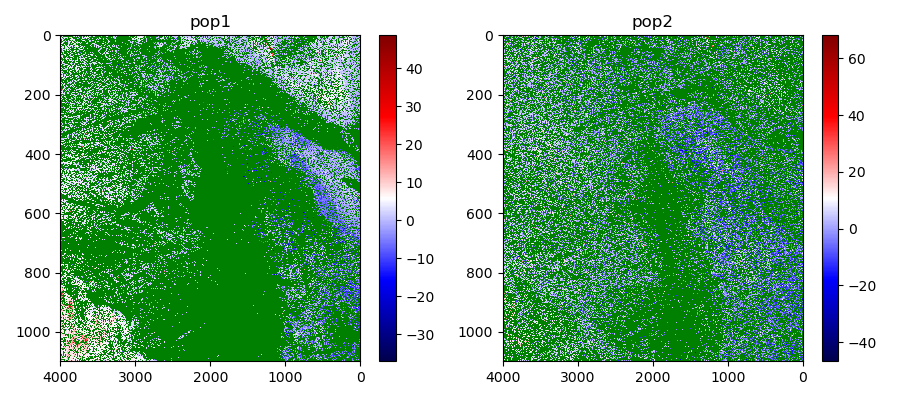

In [57]:
# plot POP 1 and POP 2
plt.figure(figsize=(9,4),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(pop1_combo,aspect='auto',interpolation='none',cmap=seismic2); plt.colorbar()
plt.xlim([dx,0])
plt.title('pop1')
plt.subplot(1,2,2)
plt.imshow(pop2_combo,aspect='auto',interpolation='none',cmap=seismic2); plt.colorbar()
plt.title('pop2')
plt.xlim([dx,0])
plt.show()

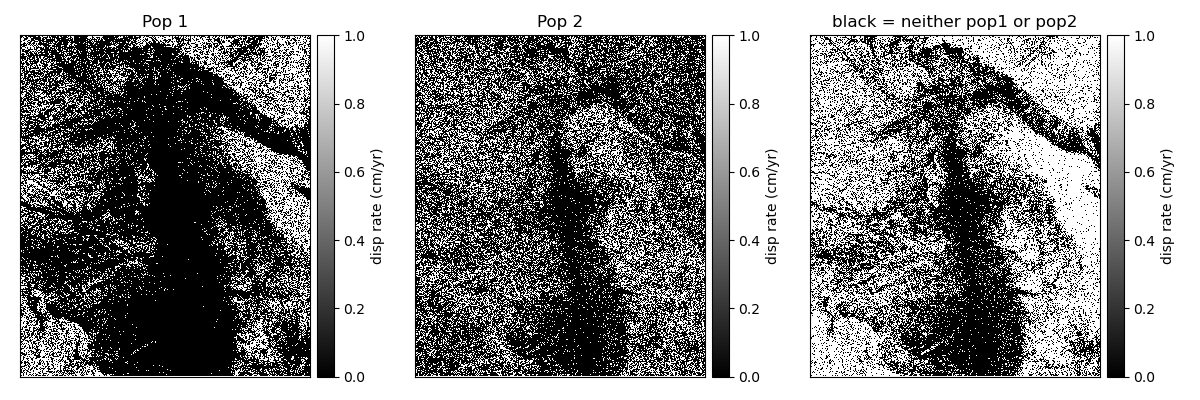

In [58]:
neither_pop12 = (pop1_combo_mask + pop2_combo_mask)

plt.figure(figsize=(12,4),tight_layout=True)
plt.subplot(1,3,1)
plt.imshow(pop1_combo_mask,aspect='auto',interpolation='none')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('gray')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 1')
plt.subplot(1,3,2)
plt.imshow(pop2_combo_mask, aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('gray')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 2')
plt.subplot(1,3,3)
plt.imshow(neither_pop12, aspect='auto',interpolation='nearest') 
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('gray')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('black = neither pop1 or pop2')
plt.show()

Save the pop1 and pop2 masks as files/arrays of 0's and 1's for future use.

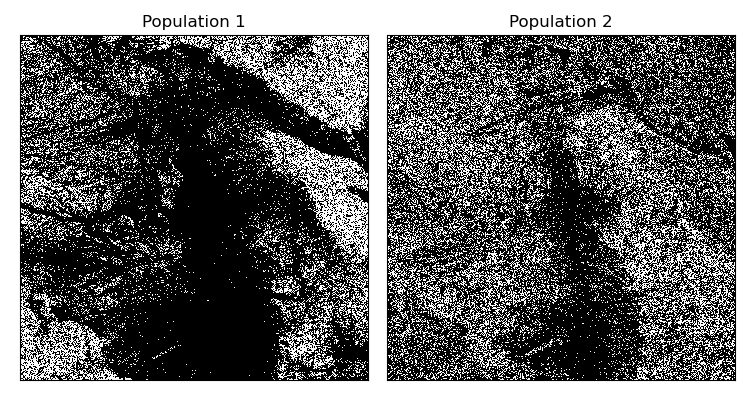

pop1: 9.93224e+05
pop2: 1321864.0


In [59]:
to_save_pop1 = np.zeros((dy,dx))
to_save_pop1[pop1_combo_mask.nonzero()] = 1.0
to_save_pop2 = np.zeros((dy,dx))
to_save_pop2[pop2_combo_mask.nonzero()] = 1.0

plt.figure(figsize=(7.5,4),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(to_save_pop1,aspect='auto',interpolation='none')
#plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('gray')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Population 1')
plt.subplot(1,2,2)
plt.imshow(to_save_pop2, aspect='auto',interpolation='nearest')
#plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('gray')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Population 2')
#plt.savefig('/data/ocp4/LagunaSalada/Data_and_Figs/17_pixel_populations/pops12.png',transparent=True)
plt.show()



# # now save them. Only needed to do this once.
# driver=gdal.GetDriverByName('ISCE')
# saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/17_pixel_populations/'
# file1 = 'pop1_mask_version2.r4'
# colds = driver.Create(saveDir+file1,dx,dy,1,gdal.GDT_Float32)
# colds.GetRasterBand(1).WriteArray(to_save_pop1)
# colds=None
# file2 = 'pop2_mask_version2.r4'
# colds = driver.Create(saveDir+file2,dx,dy,1,gdal.GDT_Float32)
# colds.GetRasterBand(1).WriteArray(to_save_pop2)
# colds=None
# print('pop1 and pop2 masks saved.')
print('pop1: '+str(np.sum(to_save_pop1)))
print('pop2: '+str(np.sum(to_save_pop2)))

Mask the loaded velocity map based on pop1 and pop2. Don't display pixels from neither pop. 

interval 2, dates: 20200418-20201208


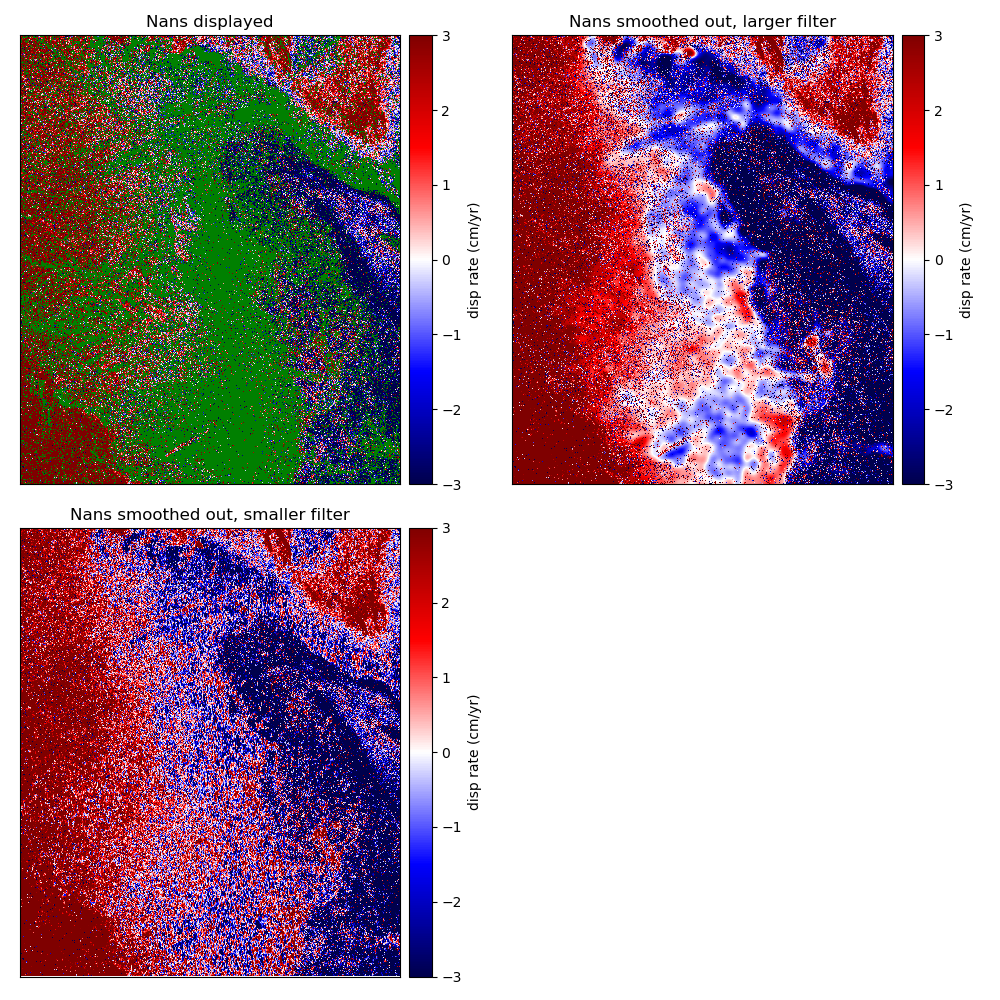

In [60]:
# mask vel map 
vel_map_masked = np.ma.masked_where(neither_pop12==0,disp_rates)

# filter size
alooks = 8                             
rlooks = 40

# now try smoothing out the masked version, then re-input the true values back in. 
vel_map_masked_smoothed = gaussian_filter(vel_map_masked,sigma=[alooks,rlooks])
vel_map_masked_smoothed[np.nonzero(vel_map_masked)] = vel_map_masked[np.nonzero(vel_map_masked)]

# try a much smaller filter
alooks2 = 2                            
rlooks2 = 2
# now try smoothing out the masked version, then re-input the true values back in. 
vel_map_masked_smoothed2 = gaussian_filter(vel_map_masked,sigma=[alooks2,rlooks2])
vel_map_masked_smoothed2[np.nonzero(vel_map_masked)] = vel_map_masked[np.nonzero(vel_map_masked)]

i = j # for 0-3 I used vmin=-5.0,vmax=5.0, but for 4-5 I used vmin=-3.0, vmax=3.0
print('interval '+str(i)+', dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.figure(figsize=(10,10),tight_layout=True)
plt.subplot(2,2,1)
plt.imshow(vel_map_masked, aspect='auto', vmin=-3.0,vmax=3.0,\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0])
#plt.xlim([1500,1510]); plt.ylim([800,810])
plt.xticks([]); plt.yticks([])
plt.title('Nans displayed')
plt.subplot(2,2,2)
plt.imshow(vel_map_masked_smoothed, aspect='auto', vmin=-3.0,vmax=3.0,\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0])
#plt.xlim([1500,1510]); plt.ylim([800,810])
plt.xticks([]); plt.yticks([])
plt.title('Nans smoothed out, larger filter')
plt.subplot(2,2,3)
plt.imshow(vel_map_masked_smoothed2, aspect='auto', vmin=-3.0,vmax=3.0,\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0])
#plt.xlim([1500,1510]); plt.ylim([800,810])
plt.xticks([]); plt.yticks([])
plt.title('Nans smoothed out, smaller filter')
plt.show()

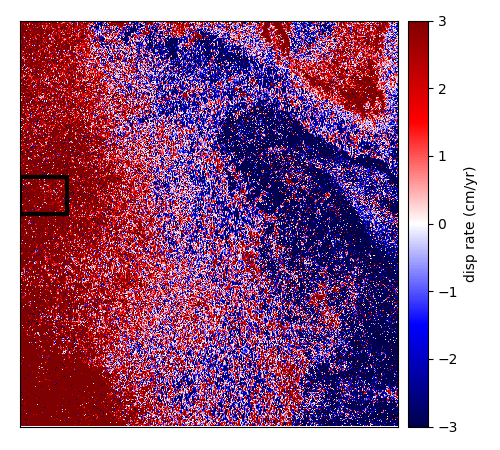

In [61]:
# for Fringe poster 2023

box1x = [3500, 4000];  box1dx = box1x[1]-box1x[0]
box1y = [425, 525];   box1dy = box1y[1]-box1y[0]

plt.figure(figsize=(5,4.5),tight_layout=True)
plt.imshow(vel_map_masked_smoothed2, aspect='auto', vmin=-3.0,vmax=3.0,\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0])
#plt.xlim([1500,1510]); plt.ylim([800,810])
plt.xticks([]); plt.yticks([])
plt.gca().add_patch(Rectangle((box1x[0],box1y[0]),box1dx,box1dy,edgecolor='k',facecolor='none',lw=3,label='box1'))
#plt.title('Nans smoothed out, smaller filter')
#plt.savefig('/data/ocp4/LagunaSalada/Data_and_Figs/17_pixel_populations/rate_map_poster.png',transparent=True)
plt.show()

Do the smoothing of pop1 and pop2 masked arrays so I can difference them. Each one takes ~23 minutes. 

In [62]:
# run the function for all the masked maps
pop1_mask_filt, pop1_smooth, var_pop1, var_mean_pop1 = mask_smooth(pop1_combo,disp_rates,dy,dx)
pop2_mask_filt, pop2_smooth, var_pop2, var_mean_pop2 = mask_smooth(pop2_combo,disp_rates,dy,dx)

kernel created.
kernel convolved with mask.
kernel convolved with masked velocities.
convolved velocities divided by convolved mask.


/tmp/ipykernel_12198/510072936.py:35: RuntimeWarning: invalid value encountered in true_divide
  ab_Nans = vels_filt / mask_filt     # start with an array that will have some Nans in it.


residuals and residuals^2 calculated between input vels and smoothed vels.
residuals convolved with window to get smoothed variances.
multiplier calcualted to get variances of vel means
smoothed variances divided by smoothed mask.
variances of mean vels calculated.


/tmp/ipykernel_12198/510072936.py:62: RuntimeWarning: invalid value encountered in true_divide
  var_ab = var_filt/mask_filt                 # divide by mask to not create edge effects that drop off to zero


kernel created.
kernel convolved with mask.
kernel convolved with masked velocities.
convolved velocities divided by convolved mask.
residuals and residuals^2 calculated between input vels and smoothed vels.
residuals convolved with window to get smoothed variances.
multiplier calcualted to get variances of vel means
smoothed variances divided by smoothed mask.
variances of mean vels calculated.


Plot them and the difference between them. 

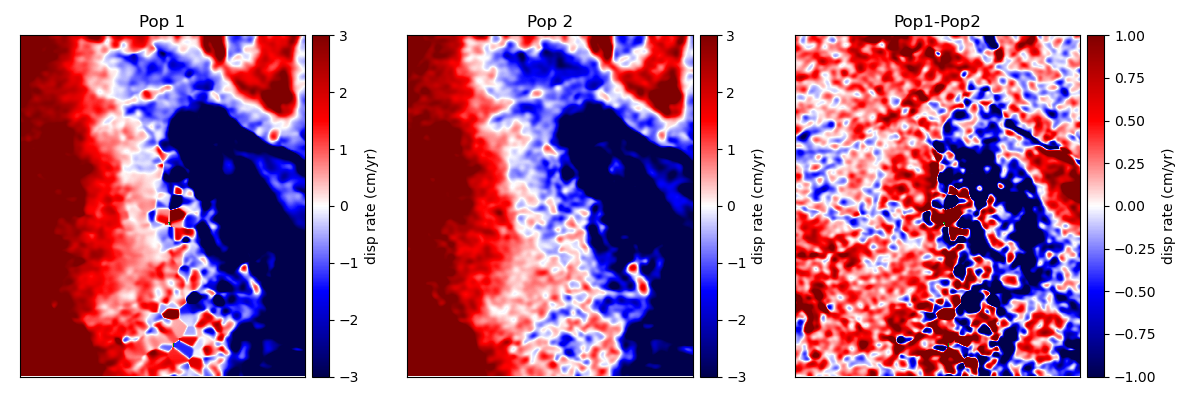

In [63]:
plt.figure(figsize=(12,4),tight_layout=True)
plt.subplot(1,3,1)
plt.imshow(pop1_smooth, aspect='auto', vmin=-3.0,vmax=3.0,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 1')
plt.subplot(1,3,2)
plt.imshow(pop2_smooth, aspect='auto', vmin=-3.0,vmax=3.0,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 2')
plt.subplot(1,3,3)
plt.imshow(pop1_smooth-pop2_smooth, aspect='auto',vmin=-1,vmax=1,interpolation='nearest') 
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop1-Pop2')
plt.show()

Plot variances of velocities and variances of velocity means for pop1 and po2.

In [ ]:
plt.figure(figsize=(10,8),tight_layout=True)
plt.subplot(2,2,1)
plt.imshow(var_pop1,cmap=seismic2,aspect='auto',interpolation='none')
plt.xlim([dx,0])
plt.title('pop1, var of vels')
plt.colorbar(label='variance (cm/yr)')
plt.subplot(2,2,2)
plt.imshow(var_pop2,cmap=seismic2,aspect='auto',interpolation='none')
plt.xlim([dx,0])
plt.title('pop2, var of vels')
plt.colorbar(label='variance (cm/yr)')
plt.subplot(2,2,3)
plt.imshow(var_mean_pop1,cmap=seismic2,aspect='auto',interpolation='none')
plt.xlim([dx,0])
plt.title('pop1, var of vel mean')
plt.colorbar(label='variance (cm/yr)')
plt.subplot(2,2,4)
plt.imshow(var_mean_pop2,cmap=seismic2,aspect='auto',interpolation='none')
plt.xlim([dx,0])
plt.title('pop2, var of vel mean')
plt.colorbar(label='variance (cm/yr)')
plt.show()

Plot Pop1-Pop2 vs. cumulative TPC. See if linear or anything other than blob.

In [ ]:
loadDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'
file_name = 'TPC_avgs.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
avg_TPCs = f1.ReadAsArray()
f1 = None
print('Avg TPC values map loaded.')

In [ ]:
plt.figure(figsize=(10,4),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(avg_TPCs,aspect='auto',vmin=-0.1,vmax=0.1)
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.title('avg TPC')
plt.colorbar(label='TPC (rad)')
plt.subplot(1,2,2)
plt.imshow(avg_TPCs*209,aspect='auto',vmin=-10,vmax=10)
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.title('cum TPC')
plt.colorbar(label='cum TPC (rad)')
plt.show()

In [ ]:
# average mean TPC over box 1
box1x = [3500, 4000];  box1dx = box1x[1]-box1x[0]
box1y = [425, 525];   box1dy = box1y[1]-box1y[0]

print(np.mean(avg_TPCs[box1y[0]:box1y[1],box1x[0]:box1x[1]]))

In [ ]:
print(-0.006086481*209)
# number of triplets is nd-2 which is 209

In [ ]:
import matplotlib.colors as mcolors
pop_diffs_flat = (pop1_smooth-pop2_smooth).flatten()
avg_TPCs_flat = avg_TPCs.flatten()

plt.figure(figsize=(6,4),tight_layout=True)
plt.hist2d(pop_diffs_flat[~np.isnan(pop_diffs_flat)],avg_TPCs_flat[~np.isnan(pop_diffs_flat)],bins=200,norm=mcolors.LogNorm()) #,cmin=1,cmax=1000
plt.colorbar(label='pixel density'); plt.set_cmap('plasma') # plasma is original 
plt.ylim([-0.05,0.05])
plt.xlim([-1,1])
plt.ylabel('Avg TPC (rad)')
plt.xlabel('Pop1-Pop2 velocities (cm/yr)')
plt.show()

Combined variances of pop1 and pop2.

In [ ]:
std_mean_vels = np.sqrt(var_mean_pop1+var_mean_pop2)

plt.figure(figsize=(6,6),tight_layout=True)
plt.imshow(std_mean_vels,cmap=seismic2,aspect='auto',interpolation='none')
plt.xlim([dx,0])
plt.title('stds of velocity mean differences,\nboth pop1 and pop2')
plt.colorbar(label='standard deviation (cm/yr)')
plt.xlabel('range'); plt.ylabel('azimuth')
plt.xticks([]); plt.yticks([])
plt.show()

In [ ]:
print(np.nanpercentile(std_mean_vels.flatten(),95))
print(np.nanpercentile(std_mean_vels.flatten(),10))

# maybe mask anything with std > 0.03 cm/yr 

Mask the rate diffs map using the combined std criteria.

In [ ]:
# started with 0.03, tried 0.025 which might be ok too.
pop_diffs = pop1_smooth-pop2_smooth
std_cutoff = 0.02
diffs_masked = np.ma.masked_where(std_mean_vels>std_cutoff,pop_diffs)

plt.figure(figsize=(6,6),tight_layout=True)
plt.imshow(diffs_masked,cmap=seismic2,aspect='auto',interpolation='none',vmin=-1,vmax=1)
plt.xlim([dx,0])
plt.title('pop1-pop2, masked by stds')
plt.colorbar(label='rate difference (cm/yr)')
plt.xlabel('range'); plt.ylabel('azimuth')
plt.xticks([]); plt.yticks([])
plt.show()

Calculate the number of pixels in each window for each population. 

In [ ]:
# initialize array of Nans for each map.
num_pix_pop1 = np.zeros((dy,dx))*np.nan
num_pix_pop2 = np.zeros((dy,dx))*np.nan

# moving window size. Same as filter size from mask_smooth function.
#alooks = 4                                  # amount to filter in the azimuth/y direction
alooks = 16 # TRY THIS
ylooks = int(alooks/2)
#rlooks = 20                                 # amount to filter in the range/x direction
rlooks = 80                              
xlooks = int(rlooks/2)

# loop through pixels 
for y in range(dy):     #dy
    for x in range(dx): #dx
        # only if not an edge pixel
        if y-ylooks >= 0 and y+ylooks < dy and x-xlooks >= 0 and x+xlooks < dx:
            num_pix_pop1[y,x] = np.sum(pop1_combo_mask[y-ylooks:y+ylooks,x-xlooks:x+xlooks]) # pop1_combo_mask is 1's and 0's so it will add up how many pixels are in pop1 in that window.
            num_pix_pop2[y,x] = np.sum(pop2_combo_mask[y-ylooks:y+ylooks,x-xlooks:x+xlooks])
pix_density_pop1 = num_pix_pop1/(alooks*rlooks)
pix_density_pop2 = num_pix_pop2/(alooks*rlooks)

In [ ]:
gray2 = plt.cm.get_cmap("gray").copy()
gray2.set_bad(color='green')
print('colormap made where NANs will be green.')

In [ ]:
plt.figure(figsize=(8,4),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(pix_density_pop1*100, aspect='auto',interpolation='nearest',vmin=0.00000001,vmax=100)
plt.colorbar(orientation='vertical',pad=0.02,label='pix density (%)')
plt.set_cmap(gray2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 1, pixel density')
plt.subplot(1,2,2)
plt.imshow(pix_density_pop2*100, aspect='auto', interpolation='nearest',vmin=0.00000001,vmax=100)
plt.colorbar(orientation='vertical',pad=0.02,label='pix density (%)')
plt.set_cmap(gray2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 2, pixel density')
plt.show()

In [ ]:
plt.figure(figsize=(8,4),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(pop1_mask_filt*100, aspect='auto',interpolation='nearest',vmin=0,vmax=100)
plt.colorbar(orientation='vertical',pad=0.02,label='weighted pix density (~%)')
plt.set_cmap(gray2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
# plt.title('Pop 1 mask filt')
plt.title('Pop 1 pixel density')
plt.subplot(1,2,2)
plt.imshow(pop2_mask_filt*100, aspect='auto', interpolation='nearest',vmin=0,vmax=100)
plt.colorbar(orientation='vertical',pad=0.02,label='weighted pix density (~%)')
plt.set_cmap(gray2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
#plt.title('Pop 2 mask filt')
plt.title('Pop 2 pixel density')
plt.show()

In [ ]:
print(np.nanmean(pix_density_pop1/pop1_mask_filt))
print(np.nanmean(pix_density_pop2/pop2_mask_filt))
# 
# plt.figure(figsize=(8,4),tight_layout=True)
# plt.subplot(1,2,1)
# plt.imshow(pix_density_pop1/pop1_mask_filt, aspect='auto',interpolation='nearest')
# plt.colorbar(orientation='vertical',pad=0.02,label='weighted pix density')
# plt.set_cmap(gray2)
# plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
# plt.title('pix density/Pop 1 mask filt')
# plt.subplot(1,2,2)
# plt.imshow(pix_density_pop2/pop2_mask_filt, aspect='auto', interpolation='nearest')
# plt.colorbar(orientation='vertical',pad=0.02,label='weighted pix density')
# plt.set_cmap(gray2)
# plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
# plt.title('pix density/Pop 2 mask filt')
# plt.show()
# 

^ The average of those being ~1 means that mask_smooth number corresponds to the pixel density by ~1:1. So if mask_smooth is 0.1, that corresponds to about 10% pixel density in the window. Start with a cutoff like that. 

In [ ]:
print(np.nanpercentile(pop1_mask_filt.flatten(),90))
print(np.nanpercentile(pop1_mask_filt.flatten(),20))

print(np.nanpercentile(pop2_mask_filt.flatten(),90))
print(np.nanpercentile(pop2_mask_filt.flatten(),20))

# maybe mask anything with std > 0.03 cm/yr 

In [ ]:
viridis2 = plt.cm.get_cmap("viridis").copy()
viridis2.set_under(color='red')

plt.figure(figsize=(8,8),tight_layout=True)
plt.subplot(2,2,1)
plt.imshow(num_pix_pop1, aspect='auto',interpolation='nearest',vmin=0,vmax=alooks*rlooks)
plt.colorbar(orientation='vertical',pad=0.02,label='pix density (%)')
plt.set_cmap(viridis2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 1, Num pix in window')
plt.subplot(2,2,2)
plt.imshow(num_pix_pop2, aspect='auto', interpolation='nearest',vmin=0,vmax=alooks*rlooks)
plt.colorbar(orientation='vertical',pad=0.02,label='pix density (%)')
plt.set_cmap(viridis2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 2, Num pix in window')
plt.subplot(2,2,3)
plt.imshow(num_pix_pop1-1, aspect='auto', interpolation='nearest',vmin=0,vmax=15)
plt.colorbar(orientation='vertical',pad=0.02,label='pix density (%)')
plt.set_cmap(viridis2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 1, Num pix in window - 1')
plt.subplot(2,2,4)
plt.imshow(num_pix_pop2-1, aspect='auto', interpolation='nearest',vmin=0,vmax=15)
plt.colorbar(orientation='vertical',pad=0.02,label='pix density (%)')
plt.set_cmap(viridis2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 2, Num pix in window - 1')
plt.show()

print(np.nanmin((num_pix_pop1-1).flatten()))
print(np.nanmin((num_pix_pop2-1).flatten()))

Now plot the smoothed vel rate maps for pop1 and pop2 and their differences, masked by 2 things: not enough pixel density (~10%?) and too high std of combined velocity means.

In [ ]:
# mask 
pop1_smooth_masked = np.copy(pop1_smooth)
pop2_smooth_masked = np.copy(pop2_smooth)
diffs_masked = pop1_smooth - pop2_smooth
# where combined std is too high
pop1_smooth_masked[std_mean_vels>std_cutoff] = np.nan
pop2_smooth_masked[std_mean_vels>std_cutoff] = np.nan
diffs_masked[std_mean_vels>std_cutoff] = np.nan
# where not enough pixel density 
pix_density_threshold = 0.02
pop1_smooth_masked[pop1_mask_filt<pix_density_threshold] = np.nan
pop1_smooth_masked[pop2_mask_filt<pix_density_threshold] = np.nan
pop2_smooth_masked[pop1_mask_filt<pix_density_threshold] = np.nan
pop2_smooth_masked[pop2_mask_filt<pix_density_threshold] = np.nan
diffs_masked[pop1_mask_filt<pix_density_threshold] = np.nan
diffs_masked[pop2_mask_filt<pix_density_threshold] = np.nan

plt.figure(figsize=(13,4),tight_layout=True)
plt.subplot(1,3,1)
plt.imshow(pop1_smooth_masked, aspect='auto', vmin=-3.0,vmax=3.0,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Population 1')
plt.subplot(1,3,2)
plt.imshow(pop2_smooth_masked, aspect='auto', vmin=-3.0,vmax=3.0,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Population 2')
plt.subplot(1,3,3)
plt.imshow(diffs_masked, aspect='auto',vmin=-1,vmax=1,interpolation='nearest') 
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop1-Pop2')
plt.savefig('/data/ocp4/LagunaSalada/Data_and_Figs/17_pixel_populations/pops12_diffs_poster.png',transparent=True)
plt.show()

Maybe try separating LS vs non-LS pixels and see why that explains the two-humped histogram of rate differences.

In [ ]:
load = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/masks/LS_mask.r4'
f1 = gdal.Open(load, gdal.GA_ReadOnly)
LS_mask = f1.ReadAsArray()
f1 = None
print('LS mask loaded.')

load = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/masks/mtns_mask.r4'
f1 = gdal.Open(load, gdal.GA_ReadOnly)
mtns_mask = f1.ReadAsArray()
f1 = None
print('Mountains mask loaded.')

In [ ]:
# plot LS pixels and desert pixels and their rate diffs btw populations 1,2
# EXCLUDE MASKED PIXELS LIKE ABOVE
LS_diffs_2 = np.zeros((dy,dx))*np.nan
LS_diffs_2[LS_mask.nonzero()] = diffs_masked[LS_mask.nonzero()]

desert_diffs_2 = np.copy(diffs_masked)
desert_diffs_2[LS_mask==1] = np.nan
desert_diffs_2[mtns_mask==1] = np.nan

mtns_diffs_2 = np.zeros((dy,dx))*np.nan
mtns_diffs_2[mtns_mask.nonzero()] = diffs_masked[mtns_mask.nonzero()]


In [ ]:

# hist ignores nans which is what we want.
bins = np.linspace(-1,1,200)
plt.figure(figsize=(4,4),tight_layout=True)
mtns_median_2 = np.nanmedian((mtns_diffs_2).flatten())
#plt.hist((mtns_diffs_2).flatten(),bins=bins,label='mountains',alpha=0.7,color='k') 
LS_median_2 = np.nanmedian((LS_diffs_2).flatten())
#plt.hist((LS_diffs_2).flatten(),bins=bins,label='LS',alpha=0.7,color='tab:blue') 
desert_median_2 = np.nanmedian((desert_diffs_2).flatten())
plt.hist((desert_diffs_2).flatten(),bins=bins,label='desert',alpha=0.7,color='tab:orange') 
#plt. yscale('log')

plt.xlim([-0.75,0.75])
ymin,ymax = plt.gca().get_ylim()
plt.vlines(LS_median_2,ymin,ymax,color='tab:blue',linewidth=2,label='Laguna Salada')
plt.vlines(desert_median_2,ymin,ymax,linewidth=2,color='tab:orange')
plt.vlines(mtns_median_2,ymin,ymax,color='k',linewidth=2,label='mountains')
plt.ylim([ymin,ymax])
plt.ylabel('Number of pixels')
plt.xlabel('Pop1-Pop2 velocities (cm/yr)')
plt.legend(loc='center left')

plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
#plt.savefig('/data/ocp4/LagunaSalada/Data_and_Figs/17_pixel_populations/hist_rate_diffs.png',transparent=True)
plt.show()

print(LS_median_2)
print(desert_median_2)
print(mtns_median_2)